# Bankruptcy Prediction - Key Decision Rationale

Dataset: [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction)  

## 1. Choosing the Initial Models
- **Benchmark**: Logistic Regression → interpretable baseline for comparison; fast to train; shows if complexity is needed.
- **Tree-based models**: XGBoost, Random Forest, CatBoost → handle non-linear patterns & interactions; robust to outliers; less preprocessing needed.
- **SVM (RBF)** → can capture complex boundaries for small/mid datasets; good for imbalance handling with class weights.
- No clustering → task is supervised; labels available; unsupervised clustering could misgroup companies without clear bankruptcy label.

## 2. Data Pre-processing
- Logistic Regression/SVM require feature scaling → StandardScaler for normality-based models.
- Tree-based models handle raw numeric data → scaling optional.
- Encode categorical variables (if any) → OneHot or ordinal encoding depending on feature type.
- Ensure no missing values → imputation if required.

## 3. Handling Class Imbalance
- Dataset has high bankruptcy vs. non-bankruptcy skew → minority class is small.
- SMOTE → synthetic sample generation to balance classes; risk of noise if applied blindly.
- Class weighting in model → avoids artificial data creation; good for LR/SVM/tree models.
- Stratified split → maintains class ratio in train/test for fair evaluation.

## 4. Outlier Detection and Treatment
- Keep outliers that may indicate bankruptcy risk → informative to model.
- Remove only data-entry errors or irrelevant extreme noise.
- Tree-based models less sensitive → LR/SVM more sensitive → consider Winsorization for them.

## 5. Addressing Sampling Bias Across Train/Test
- Use PSI to compare feature distributions between splits → ensures test set represents real-world.
- Prevents misleading validation scores if train/test differ significantly.

## 6. Data Normalization`
- LR/SVM → require scaling (StandardScaler/MinMaxScaler).
- Tree-based models → unaffected; skip scaling for them.
- Keep normalization model in pipeline → avoid leakage.

## 7. Testing for Normality
- LR assumes linearity, not strict normality → but extreme skew may harm.
- SVM benefits from normalized distributions → consider log transform on skewed features.
- Tree models ignore distribution shape.

## 8. Dimensionality Reduction (PCA)
- **Pros**: reduces noise, mitigates multicollinearity, speeds up training.
- **Cons**: components lose direct feature meaning → hurts explainability in finance context.
- Decision: skip PCA unless dimensionality or multicollinearity becomes severe.

## 9. Feature Engineering Choices
- Possible ratio features (e.g., debt-to-asset ratio) → may improve bankruptcy prediction.
- Avoid excessive new features → risk of overfitting on small dataset.
- Keep feature set interpretable for financial compliance.

## 10. Testing and Addressing Multicollinearity
- Check with VIF & correlation matrix → drop/reduce highly correlated variables.
- LR suffers from high multicollinearity → unstable coefficients.
- Tree models handle collinearity but may waste splits → minor efficiency loss.

## 11. Feature Selection Methods
- Use model-based importance (XGBoost gain) + correlation filtering.
- Drop redundant, low-importance features to improve speed & interpretability.
- Too many irrelevant features → noise; too few → underfitting.

## 12. Hyperparameter Tuning Methods
- Random search → faster coverage than grid for large space.
- Fine-tune with Bayesian Optimization (Optuna) for best parameters on top performers.
- Apply cross-validation during tuning to avoid overfitting.

## 13. Cross-Validation Strategy
- Stratified K-Fold (k=5 or 10) → maintains class ratio; stable metric estimates.
- Avoid simple holdout → unreliable with imbalance.

## 14. Evaluation Metrics Selection
- Primary: ROC-AUC → balanced performance measure under imbalance.
- Secondary: F1-score → ensures balance between precision & recall for bankruptcy class.
- PR-AUC → especially useful when minority class is rare.
- Predict_proba(X) preferred → enables threshold tuning.

## 15. Evaluating Drift and Model Degradation
- Monitor PSI between training & incoming production data → detect feature distribution shifts.
- Early detection prevents silent accuracy drops over time.

## 16. Interpreting Model Results and Explainability
- SHAP → global & local interpretability for tree models.
- Logistic Regression coefficients → simple interpretation for baseline.
- Improves trust for stakeholders, essential in regulated financial decisions.


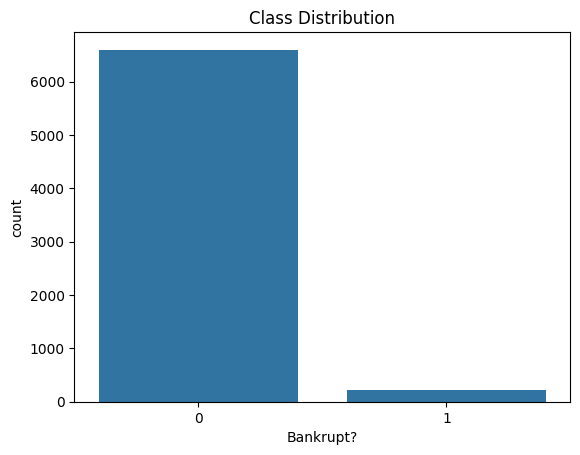

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data.csv")
df.head()

# Class distribution
sns.countplot(x='Bankrupt?', data=df)
plt.title("Class Distribution")
plt.show()

df['Bankrupt?'].value_counts(normalize=True)


In [6]:
import numpy as np

def psi(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.arange(0, buckets+1) * (100/buckets))
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    psi_value = np.sum((expected_counts - actual_counts) * np.log(expected_counts / actual_counts))
    return psi_value

# Train-test split (stratified)
from sklearn.model_selection import train_test_split
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# PSI for each feature
psi_scores = {col: psi(X_train[col], X_test[col]) for col in X.columns}
psi_df = pd.DataFrame(list(psi_scores.items()), columns=["Feature", "PSI"]).sort_values(by="PSI", ascending=False)

psi_df


C:\Users\rvith\AppData\Local\Temp\ipykernel_42804\2102122978.py:8: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_counts - actual_counts) * np.log(expected_counts / actual_counts))
C:\Users\rvith\AppData\Local\Temp\ipykernel_42804\2102122978.py:8: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_counts - actual_counts) * np.log(expected_counts / actual_counts))


,Feature,PSI
51,Operating profit per person,0.014873
12,Cash flow rate,0.014848
61,Inventory/Working Capital,0.014735
8,Non-industry income and expenditure/revenue,0.014200
64,Working Capital/Equity,0.013488
...,...,...
40,Contingent liabilities/Net worth,NaN
66,Long-term Liability to Current Assets,NaN
78,Equity to Long-term Liability,NaN
84,Liability-Assets Flag,NaN
